In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
root_dir = '/kaggle/input/'
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.getcwd(), os.listdir(os.getcwd())
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ship-good1/pexels-fred-9100844.jpg
/kaggle/input/ship-bad1/0_32.png


('/kaggle/working', ['__notebook__.ipynb'])

In [2]:
!git clone https://github.com/openai/CLIP
!git clone https://github.com/crowsonkb/guided-diffusion
!pip install -e ./CLIP
!pip install -e ./guided-diffusion
!pip install lpips

Cloning into 'CLIP'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 8.92 MiB | 23.41 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Cloning into 'guided-diffusion'...
remote: Enumerating objects: 102, done.
remote: Total 102 (delta 0), reused 0 (delta 0), pack-reused 102
Receiving objects: 100% (102/102), 60.98 KiB | 1.27 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Obtaining file:///kaggle/working/CLIP
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.4 MB/s eta 0:00:00
  Running setup.py develop for clip
Obtaining file:///kaggle/working/guided-diffusion
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.6 MB/s eta 0:00:00
  Running setup.py develop for guided-diffusion
     ━━━━━━━━━━━━━━━━━━

In [3]:
!curl -OL 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2108M  100 2108M    0     0  41.8M      0  0:00:50  0:00:50 --:--:-- 33.1M


In [4]:
# Imports

import gc
import io
import math
import sys

from IPython import display
import lpips
from PIL import Image
import requests
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')

import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

In [5]:
# Define necessary functions

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])

In [6]:
model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': False,
    'diffusion_steps': 1000,
    'rescale_timesteps': True,
    'timestep_respacing': '1000',  # Modify this value to decrease the number of
                                   # timesteps.
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})

In [7]:
# Load models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load('256x256_diffusion_uncond.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)

Using device: cuda:0


100%|███████████████████████████████████████| 335M/335M [00:15<00:00, 22.4MiB/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /opt/conda/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


['pexels-fred-9100844.jpg']

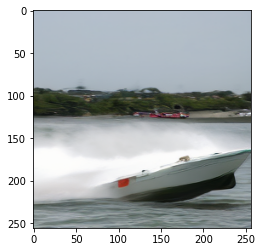

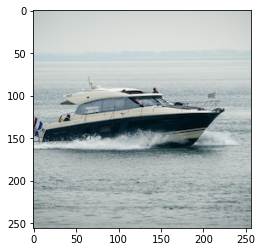

In [8]:
import matplotlib.pyplot as plt# !pip3 install -e guided-diffusion
import matplotlib.image as mpimg
# !python3 setup.py install
os.listdir(root_dir+'ship-bad1/')
os.listdir(root_dir+'ship-good1/')
os.listdir(root_dir+'ship-bad1')
plt.imshow(mpimg.imread(root_dir+'ship-bad1/0_32.png') )
plt.figure()
plt.imshow(mpimg.imread(root_dir+'ship-good1/pexels-fred-9100844.jpg') )
os.listdir(root_dir+'ship-good1')

In [9]:
prompts = ['score > 0.7']
image_prompts = [root_dir+'ship-good1/pexels-fred-9100844.jpg:0.5']
batch_size = 1
clip_guidance_scale = 1000  # Controls how much the image should look like the prompt.
tv_scale = 150              # Controls the smoothness of the final output.
range_scale = 50            # Controls how far out of range RGB values are allowed to be.
cutn = 16
n_batches = 1
init_image = root_dir+'ship-bad1/0_32.png'   # This can be an URL or Colab local path and must be in quotes.
skip_timesteps = 300  # This needs to be between approx. 200 and 500 when using an init image.
                    # Higher values make the output look more like the init.
init_scale = 0      # This enhances the effect of the init image, a good value is 1000.
seed = 0

In [10]:
inp=['a:0.5']
for i in inp:
    print(i)
parse_prompt(i)

a:0.5


('a', 0.5)

Reading img prompt.. /kaggle/input/ship-good1/pexels-fred-9100844.jpg 0.5
Reading Low Quality Imag Input: /kaggle/input/ship-bad1/0_32.png


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


  0%|          | 0/700 [00:00<?, ?it/s]


Batch 0, step 0, output 0:


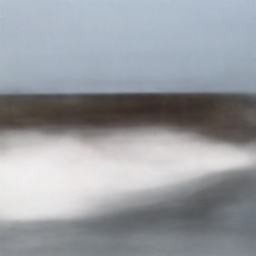


Batch 0, step 100, output 0:


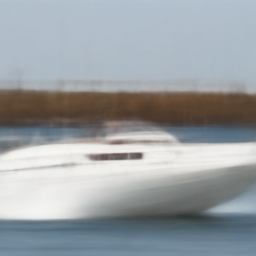


Batch 0, step 200, output 0:


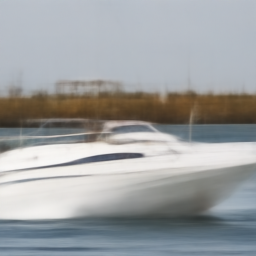


Batch 0, step 300, output 0:


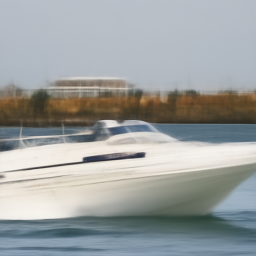


Batch 0, step 400, output 0:


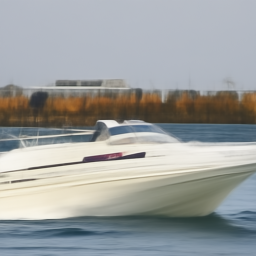


Batch 0, step 500, output 0:


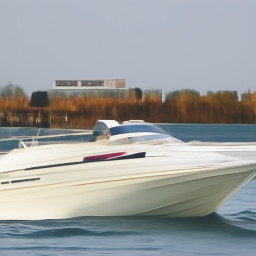


Batch 0, step 600, output 0:


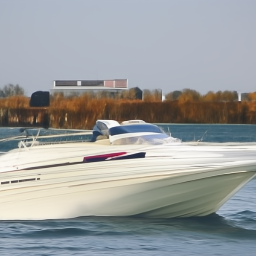


Batch 0, step 699, output 0:


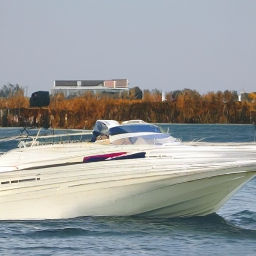

In [11]:
def do_run():
    if seed is not None:
        torch.manual_seed(seed)

    make_cutouts = MakeCutouts(clip_size, cutn)
    side_x = side_y = model_config['image_size']

    target_embeds, weights = [], []

    for prompt in prompts:
        txt, weight = parse_prompt(prompt)
        target_embeds.append(clip_model.encode_text(clip.tokenize(txt).to(device)).float())
        weights.append(weight)

    for prompt in image_prompts:
        path, weight = parse_prompt(prompt)
        #img = Image.open(fetch(path)).convert('RGB')
        print('Reading img prompt..', path, weight)
        img = Image.open(path).convert('RGB')
        img = TF.resize(img, min(side_x, side_y, *img.size), transforms.InterpolationMode.LANCZOS)
        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        embed = clip_model.encode_image(normalize(batch)).float()
        target_embeds.append(embed)
        weights.extend([weight / cutn] * cutn)

    target_embeds = torch.cat(target_embeds)
    weights = torch.tensor(weights, device=device)
    if weights.sum().abs() < 1e-3:
        raise RuntimeError('The weights must not sum to 0.')
    weights /= weights.sum().abs()

    init = None
    if init_image is not None:
        #init = Image.open(fetch(init_image)).convert('RGB')
        print('Reading Low Quality Imag Input:',init_image)
        init = Image.open(init_image).convert('RGB')
        init = init.resize((side_x, side_y), Image.LANCZOS)
        init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

    cur_t = None

    def cond_fn(x, t, y=None):
        with torch.enable_grad():
            x = x.detach().requires_grad_()
            n = x.shape[0]
            my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
            out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
            fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
            x_in = out['pred_xstart'] * fac + x * (1 - fac)
            clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
            image_embeds = clip_model.encode_image(clip_in).float()
            dists = spherical_dist_loss(image_embeds.unsqueeze(1), target_embeds.unsqueeze(0))
            dists = dists.view([cutn, n, -1])
            losses = dists.mul(weights).sum(2).mean(0)
            tv_losses = tv_loss(x_in)
            range_losses = range_loss(out['pred_xstart'])
            loss = losses.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale + range_losses.sum() * range_scale
            if init is not None and init_scale:
                init_losses = lpips_model(x_in, init)
                loss = loss + init_losses.sum() * init_scale
            return -torch.autograd.grad(loss, x)[0]

    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive

    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1

        samples = sample_fn(
            model,
            (batch_size, 3, side_y, side_x),
            clip_denoised=False,
            model_kwargs={},
            cond_fn=cond_fn,
            progress=True,
            skip_timesteps=skip_timesteps,
            init_image=init,
            randomize_class=True,
        )

        for j, sample in enumerate(samples):
            cur_t -= 1
            if j % 100 == 0 or cur_t == -1:
                print()
                for k, image in enumerate(sample['pred_xstart']):
                    filename = f'progress_{i * batch_size + k:05}.png'
                    TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    display.display(display.Image(filename))

gc.collect()
do_run()